# **AI4ER Guided Team Challenge - Slow Earthquake Time Series Forecasting**
## Applying machine learning to data from nature, the laboratory and simulations to  predict slow earthquakes
**Authors:** Camilla Giulia Billari<sup>1</sup>, Pritthijit Nath<sup>1</sup>, Jakob Poffley<sup>1</sup>, Thomas Ratsakatika<sup>1</sup>, Alexandre Shinebourne<sup>1</sup>

**Supervisor:** Adriano Gualandi<sup>1</sup>

_<sup>1</sup> University of Cambridge_

_Note: This notebook relies on the functions stored in the "utils" and "scripts/models" folders, to which all those listed above have contributed._
___

## Introduction

This notebook will enable you to train and evaluate a machine learning model on (slow) earthquake time series data from simulations, the laboratory and nature. It provides a step-by-step walkthrough of the pre-processing, feature engineer, training and evaluation functions, complementing the report and script-based implementation referenced in the README.

This notebook is designed to enable the user to easily modify the following parameters:

- **Model type:** Long Short-Term Memory (LSTM) or Temporal Convolutional Network (TCN)
- **Data source:** Simulations (b726, b698, i417), laboratory (p4581, p4679, b726, b698, i417) or nature (Cascadia)
- **Input features:** Shear stress/slip potency [required], variance, first derivative, second derivative, steps since the last peak, steps since the last trough [optional]
- **Data pre-processing:** Smoothing window, downsampling factor, validation/test set size
- **Modelling hyperparameters:** Forecast steps, lookback steps, number of epochs, hidden layer size, number of layers (LSTM only), kernel size (TCN only), dropout rate (TCN only)

Once trained, the model will generate one-shot (as opposed to auto-regressive) multi-step predictions of shear stress/slip potency. The accuracy of the model can be evaluated on using Root Mean Squared Error (RMSE) and R<sup>2</sup> statistics, as well as visually using the plotting functions.

Further details on the data and methodology, as well as an analysis and discussion of the results can be found in the accompanying report.
___

## Step 1: Environment set-up and imports

This notebook and associated functions have been built in a Conda environment within the AI4ER JASMIN group workspace. New users must therefore install the Conda environment, download the data to their working directory, and adjust the file paths to point to their working directory.

   _Note: While these models will run on a personal computer, you may run into memory limitations. Tips on how to resolve this are in Step 9._

#### Installing the Conda environment

1. Install Miniconda if required ([Windows/Linux/MacOS Instructions](https://docs.anaconda.com/free/miniconda/miniconda-install/) / [JASMIN instructions](https://help.jasmin.ac.uk/docs/software-on-jasmin/creating-and-using-miniconda-environments/))

2. Source Conda and ensure it is properly installed:

   `source ~/miniconda3/bin/activate`

   `conda --version`
3. Clone the GitHub repository (https://github.com/ai4er-cdt/earthquake-predictability.git) to your chosen location.

4. Navigate to your earthquake-predictability folder and create a Conda environment using the requirements file provided:

   `conda env create -f environment.yaml` if your machine has a GPU, otherwise use `conda env create -f environment-nogpu.yaml` 

   `conda activate gtc_env`

#### Download the slow earthquake data

1. [Download the simulation, labquake and cascadia slow earthquake data from Google Drive](https://drive.google.com/drive/folders/1PwO-OKlLo34oC8-NJ-Nd1qKLRvIdAx9n?usp=drive_link). You will need to request permission from Adriano Gualandi.

2. Save the three data folders in the following location within your working directory (create new folders as necessary): ../earthquake-predictability/data_local/gtc_quakes_data/

_Note: the "data_local" directory is required when operating outside the JASMIN AI4ER group workspace._

#### Update the paths.py script

1. Run the following code to retrieve your hostname and username:

In [1]:
import getpass
import socket

print("Host name: ", socket.gethostname())  # Retrieve the hostname of the current system to determine the environment
print("User name: ", getpass.getuser())  # Retrieve the current user's username

Host name:  gpuhost001.jc.rl.ac.uk
User name:  trr26


2. Open "../earthquake-predictability/utils/paths.py" in a code editor of your choice.
3. Replace "new_user" in line 49 with your username. Replace "new_user_working_directory" in line 50 with the path to your cloned directory:

    `if "new_user" in username:`

    `   MAIN_DIRECTORY = "new_user_working_directory"`

    *Note:* if you are on JASMIN (i.e. your hostname ends with jasmin.ac.uk or jc.rl.ac.uk) you must instead change the "MAIN_DIRECTORY" path in line 32:

    `MAIN_DIRECTORY = (`

    `   f"/gws/nopw/j04/ai4er/users/{jasmin_user}/earthquake-predictability"`
        
    `)`
4. Save your changes to paths.py.

### Imports

You should now be able to run the following cell which:

- Sets the system directories
- Imports the standard and custom functions
- Sets the random seed for Numpy and PyTorch
- Checks if a GPU is available

In [2]:
# Set the system directories
import sys
import os
import socket
from utils.paths import MAIN_DIRECTORY
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import the standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle

# Import local modules - note: dependent on above path being set correctly
import scripts.models.lstm_oneshot_multistep as lstm
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    create_dataset,
    moving_average_causal_filter,
    split_train_test_forecast_windows,
    find_peak_indices,
    create_features,
    normalise_dataset_multi_feature,
    select_features
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import train_model_multi_feature, eval_model_on_test_set_multi_feature
from utils.plotting import plot_random_window, plot_random_test_window

# Set a random seed
SEED = 42
set_seed(SEED)

# Set the PyTorch device (GPU/cuda or CPU)
device = set_torch_device()

# If the notebook is being run on the JASMIN GPU cluster, select the second GPU (index = 1)
if socket.gethostname() == "gpuhost001.jc.rl.ac.uk":
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


___
## Step 2: Select an experiment and load the data

The data you have downloaded includes shear stress (MPa) time series for:

- Labquake experiments conducted by Marone et al. (p4679, p4581)
- Labquake experiments conducted by Mele Veedu et al. (b726, b698, i417)
- Simulations of the Mele Veedu et al. labquake experiments conducted by Gualandi et al. (sim_b726, sim_b698, sim_i417)

You also have slip potency (a measure of displacement along a fault in m<sup>3</sup>) time series for Cascadia from Michel et al.

[A plot of the experiment and Cascadia time series can be found here](./images/trr26-notebooks/all_exp_shear_stress.png). Specific details on each time series can be found in the report.

**Update the variable "exp" in the cell below with the experiment you want to train a model on.** Enter either "b726", "b698", "i417", "p4679", "p4581", "sim_b726", "sim_b698", "sim_i417" or "cascadia".

The "SlowEarthquakeDataset" class loads the shear stress/slip potency for the chosen experiment, ignoring any other columns (e.g. normal stress). It then converts the data into a dataframe, "df", which contains a single column called "signal". A sample from df is then printed, alongside its shape for inspection.

In [3]:
exp = "p4679"    # Set this to the name of the experiment you want to train on

if exp == "cascadia":
    column_name = "seg_avg"
else:
    column_name = "obs_shear_stress"

dataset = SlowEarthquakeDataset(exp)
df = pd.DataFrame(
    SlowEarthquakeDataset.convert_to_df(dataset, exp)[column_name].rename(
        "signal"
    )
)

if exp == "cascadia":
    df = df / 1e8  # Scale the slip potency signal to match magnitude of lab and sim data

df

,signal
0,5.091520
1,5.090652
2,5.089989
3,5.089492
4,5.088243
...,...
301716,4.979753
301717,4.979841
301718,4.980150
301719,4.979985


___
## Step 3: Pre-process the data

The next cell applies a custom causal filter function to the signal. The function:

- Smooths the data using a trailing moving average with a window size equal to "smoothing_window".
- It then downsamples the data with a step size equal to the "downsampling_factor"

_Note: We downsample the data because each time step should represent the same amount of "movement" for all of our datasets. I.e. if it takes 30 time steps to go from a peak to a trough in Cascadia, it should take 30 time steps to do the same in our experiments. This is important because our models are trained to predict a fixed number of steps forward. This fixed "look forward" must represent the same "movement" in the simulated, laboratory and Cascadia data to enable comparison and transfer learning._

The "settings" dictionary in the cell below contains the downsampling_factors required to ensure the experiment data aligns with Cascadia. [A plot of the aligned data can be viewed here](./images/trr26-notebooks/downsampling_alignment.png) (the black dotted lines represent 30 time steps).

The dictionary also includes smoothing_window sizes for each experiment  which you can adjust if required.  

In [4]:
# Define smoothing window and downsampling factor for each experiment (must be integers)
settings = {
    "cascadia": {"smoothing_window": 10, "downsampling_factor": 1},
    "p4679": {"smoothing_window": 20, "downsampling_factor": 13},
    "p4581": {"smoothing_window": 30, "downsampling_factor": 26},
    "b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "i417": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "sim_b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_i417": {"smoothing_window": 2, "downsampling_factor": 2},
}

df_filtered = moving_average_causal_filter(df, **settings[exp])

df_filtered

,signal
0,5.067449
1,4.987701
2,4.912222
3,4.899803
4,4.897135
...,...
23203,4.977414
23204,4.977963
23205,4.978566
23206,4.979127


___
## Step 4: Engineer new input features

The next cell adds engineered input features to the data frame using the "create_features" function.

This function calculates the variance, first derivative, second derivative, the times since the last peak and the steps since the last trough. The resulting dataframe now has six columns, as shown below.

_Note: All the features are added to the dataframe at this stage to enable experimentation with different feature combinations when training the model._

In [5]:
df_features = create_features(df_filtered.copy())
feature_list = df_features.columns

df_features

,signal,variance,first_derivative,second_derivative,steps_since_last_peak,steps_since_last_trough
0,4.913306,0.001122,0.000816,0.000123,29.0,29.0
1,4.914115,0.000265,0.000808,-0.000007,30.0,30.0
2,4.914815,0.000037,0.000700,-0.000108,31.0,31.0
3,4.915581,0.000039,0.000766,0.000066,32.0,32.0
4,4.916432,0.000042,0.000851,0.000085,33.0,33.0
...,...,...,...,...,...,...
23174,4.977414,0.000025,0.000609,0.000080,189.0,128.0
23175,4.977963,0.000025,0.000550,-0.000059,190.0,129.0
23176,4.978566,0.000025,0.000602,0.000053,191.0,130.0
23177,4.979127,0.000025,0.000561,-0.000041,192.0,131.0


### Plot the data including engineered features

The next cell plots signal and engineered features for inspection. The black dotted lines align with the detected troughs of the experiment signal.

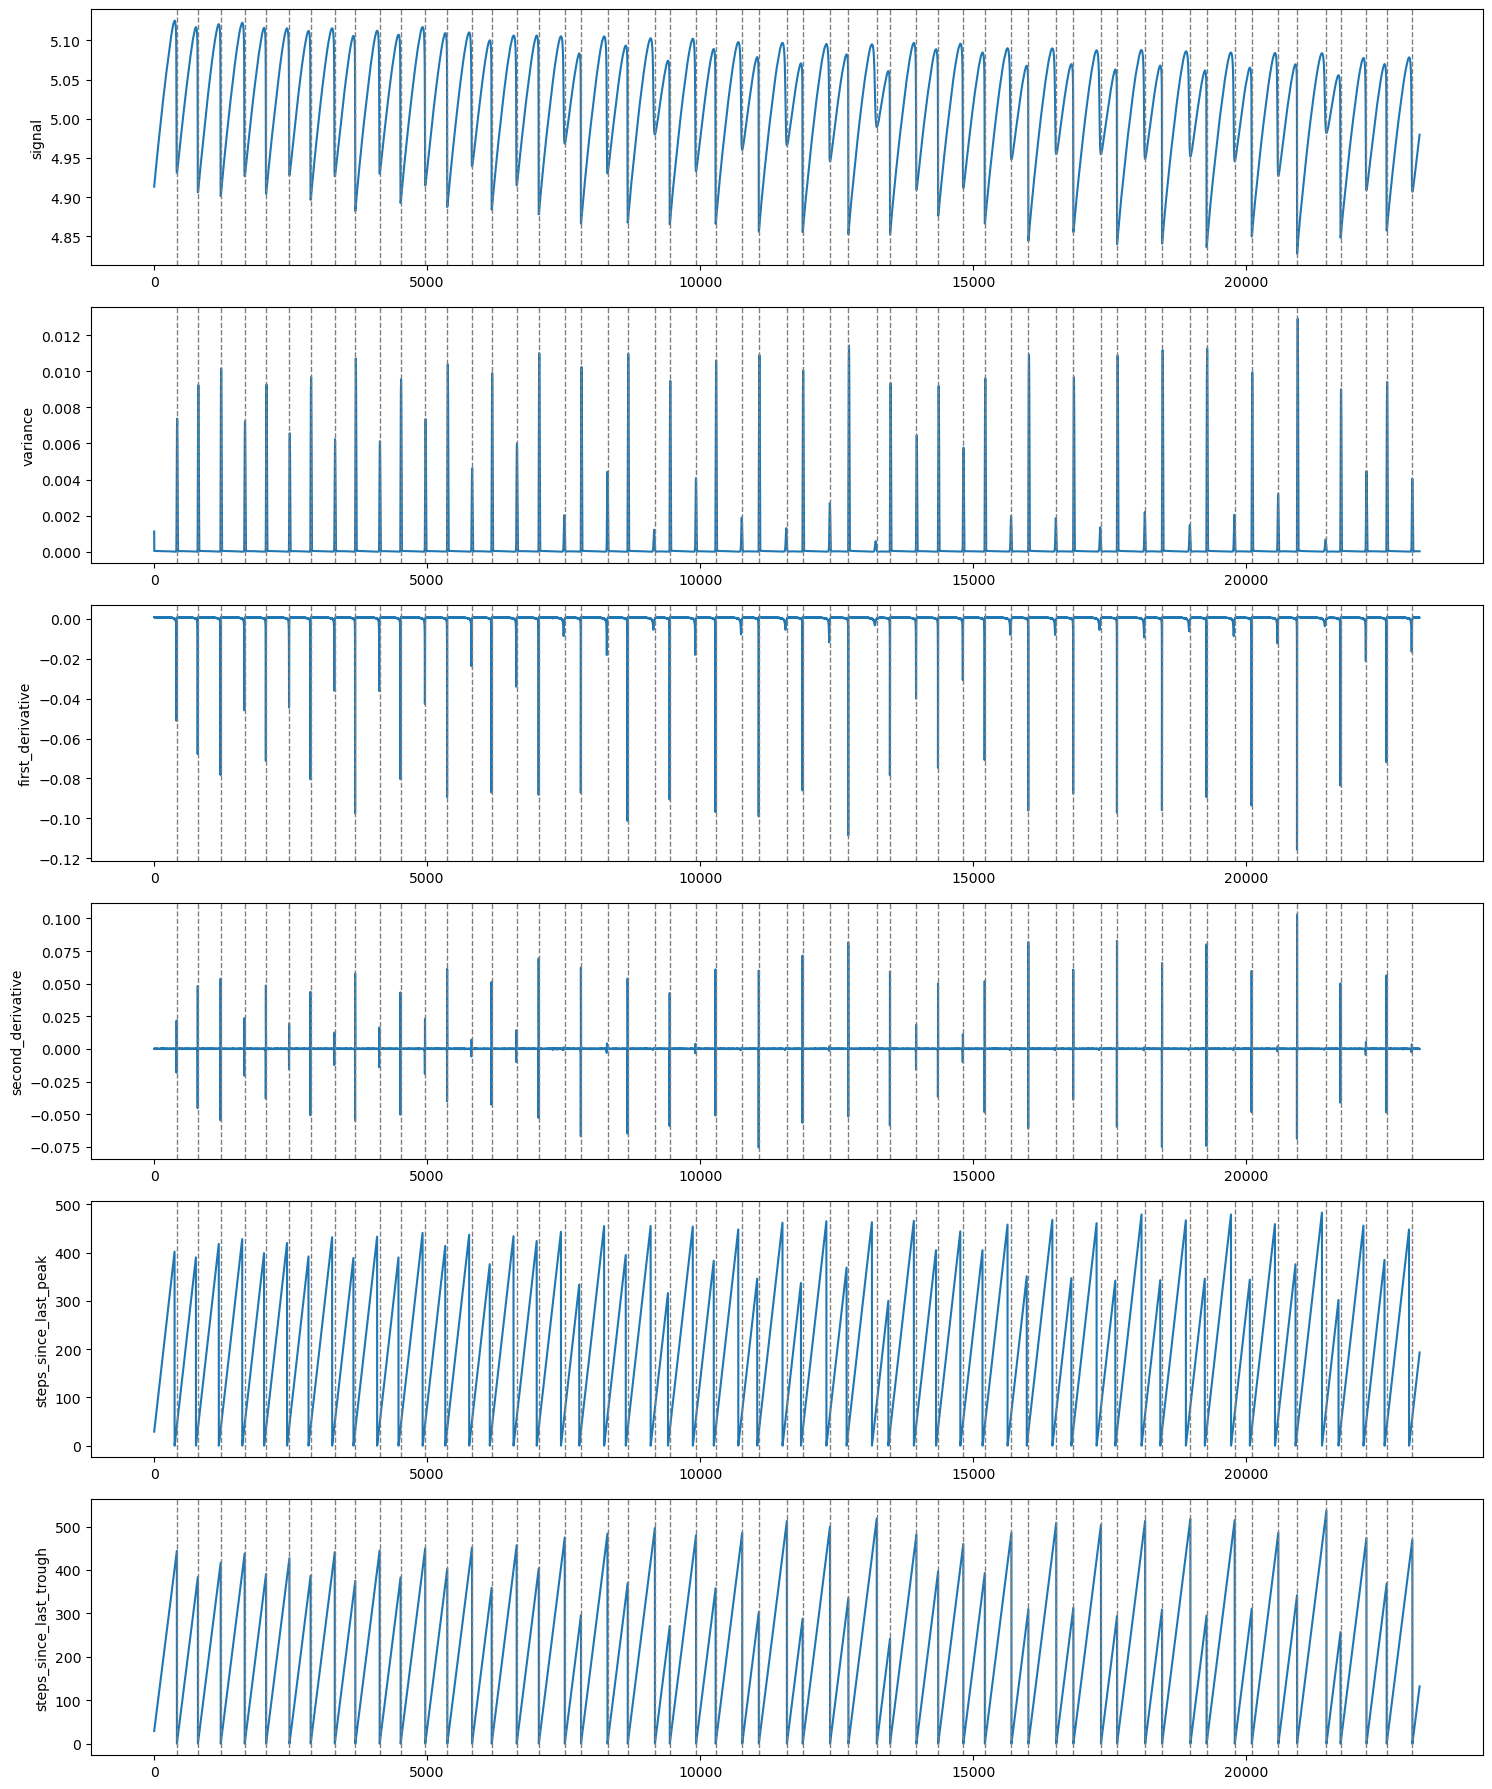

In [6]:
fig, axs = plt.subplots(
    len(df_features.columns), 1, figsize=(15, 3 * len(df_features.columns))
)

for i, column in enumerate(df_features.columns):
    ax = axs[i]
    ax.plot(df_features.index, df_features[column])
    ax.set_ylabel(column)
    ax.grid(False)

    # Mark where steps_since_last_trough = 0 with a black dashed line
    troughs_indices = df_features[
        df_features["steps_since_last_trough"] == 0
    ].index
    for trough_index in troughs_indices:
        ax.axvline(x=trough_index, color="grey", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

___
## Step 6: Create train, validation and test sets
We now need to define:

- How many steps forward we want our model to predict (FORECAST). We have set a default FORECAST value of 30 which corresponds to 30 days/1 month in Cascadia.
- How many past steps to use to calculate our prediction (LOOKBACK). We have set a default LOOKBACK value fo 600. This includes at least one previous cycle and generally results in optimal performance vs significantly longer (e.g. 1500) or shorter (e.g. 200) values.

**You can experiment with adjusting the LOOKBACK and FORECAST variables or keep them as they are.**

The "create_dataset" function then splits the dataset into multiple windows of X-y pairs, each separated by a single step, with X of length = LOOKBACK and y of length = FORECAST. It also converts the data into tensors, ready for processing with PyTorch.

In [7]:
LOOKBACK, FORECAST = 600, 30
X, y = create_dataset(df_features, LOOKBACK, FORECAST)

print(f"X and y shapes:\t{X.shape}\t{y.shape}")

X and y shapes:	torch.Size([22550, 600, 6])	torch.Size([22550, 30, 6])


We now need to define the size of our test and validation set. **A default size of 15% for the validation and test sets is used here, however you can adjust this if required.**

The remainder of this code calculates the equivalent number of forecasting windows required for testing (N_FORECAST_WINDOWS) and validation (N_VALIDATION_WINDOWS).

In [8]:
test_set_percentage = 0.15  # User-defined percentage of the data reserved for testing
validation_set_percentage = 0.15  # User-defined percentage of the data reserved for validation

total_samples = len(X)  # Total number of samples in the dataset
forecast_horizon = FORECAST  # How many time steps you want to predict into the future

# Calculate the number of samples for the test and validation sets
test_set_size = int(np.floor(total_samples * test_set_percentage))
validation_set_size = int(np.floor(total_samples * validation_set_percentage))

# Calculate the number of forecast and validation windows
# The "//" operator performs integer division
N_FORECAST_WINDOWS = test_set_size // forecast_horizon
N_VALIDATION_WINDOWS = validation_set_size // forecast_horizon

# Print out the calculated sizes for verification
print(f"Number of forecast windows for testing: {N_FORECAST_WINDOWS}")
print(f"Number of forecast windows for validation: {N_VALIDATION_WINDOWS}")

Number of forecast windows for testing: 112
Number of forecast windows for validation: 112


The "split_train_test_forecast_windows" function now splits these X-y pairs into train, validation and test sets based on the respective number of windows. The size of the resulting tensors are then displayed for reference.

In [9]:
(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print("Split dataset statistics:")
print(f"Training data shapes:\t\t{X_train.shape}\t\t{y_train.shape}")
print(f"Testing data shapes:\t\t{X_val.shape}\t\t{y_val.shape}")
print(f"Validation data shapes:\t\t{X_test.shape}\t\t{y_test.shape}")

Split dataset statistics:
Training data shapes:		torch.Size([15810, 600, 6])		torch.Size([15810, 30, 6])
Testing data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])
Validation data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])


___
## Step 7: Normalisation

The "normalise_dataset_multi_feature" function normalises the data using either a min-max or standard scalar and loads all the data into a dictionary. **You can set the normalisation type (min-max or standard) by adjusting the "scaler" variable.** A separate scalar is created for each feature, fitted to the X values and then applied to the X and y values.

In [10]:
scaler = "min-max"  # Set to either standard or min-max

data_dict_temp, scalers_X, scalers_y = normalise_dataset_multi_feature(
    X_train, y_train, X_test, y_test, X_val, y_val, scaler
)

print(f"Data Dictionary keys:\t{data_dict_temp.keys()}")
print("------------------")
print("Original dataset statistics:")
print(f"Training data shapes:\t\t{data_dict_temp['X_train'].shape}\t\t{data_dict_temp['y_train'].shape}")
print(f"Testing data shapes:\t\t{data_dict_temp['X_val'].shape}\t\t{data_dict_temp['y_val'].shape}")
print(f"Validation data shapes:\t\t{data_dict_temp['X_test'].shape}\t\t{data_dict_temp['y_test'].shape}")
print("------------------")
print("Normalised dataset statistics:")
print(f"Training data shapes:\t\t{data_dict_temp['X_train_sc'].shape}\t\t{data_dict_temp['y_train_sc'].shape}")
print(f"Validation data shapes:\t\t{data_dict_temp['X_val_sc'].shape}\t\t{data_dict_temp['y_val_sc'].shape}")
print(f"Testing data shapes:\t\t{data_dict_temp['X_test_sc'].shape}\t\t{data_dict_temp['y_test_sc'].shape}")

Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([15810, 600, 6])		torch.Size([15810, 30, 6])
Testing data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])
Validation data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([15810, 600, 6])		torch.Size([15810, 30, 6])
Validation data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])
Testing data shapes:		torch.Size([3360, 600, 6])		torch.Size([3360, 30, 6])


___
## Step 8: Select the required features for training

The "plot_random_window" function plots a random window from the training set, which has now been split into X-y pairs and normalised. **You can run the cell multiple times to view different windows.**

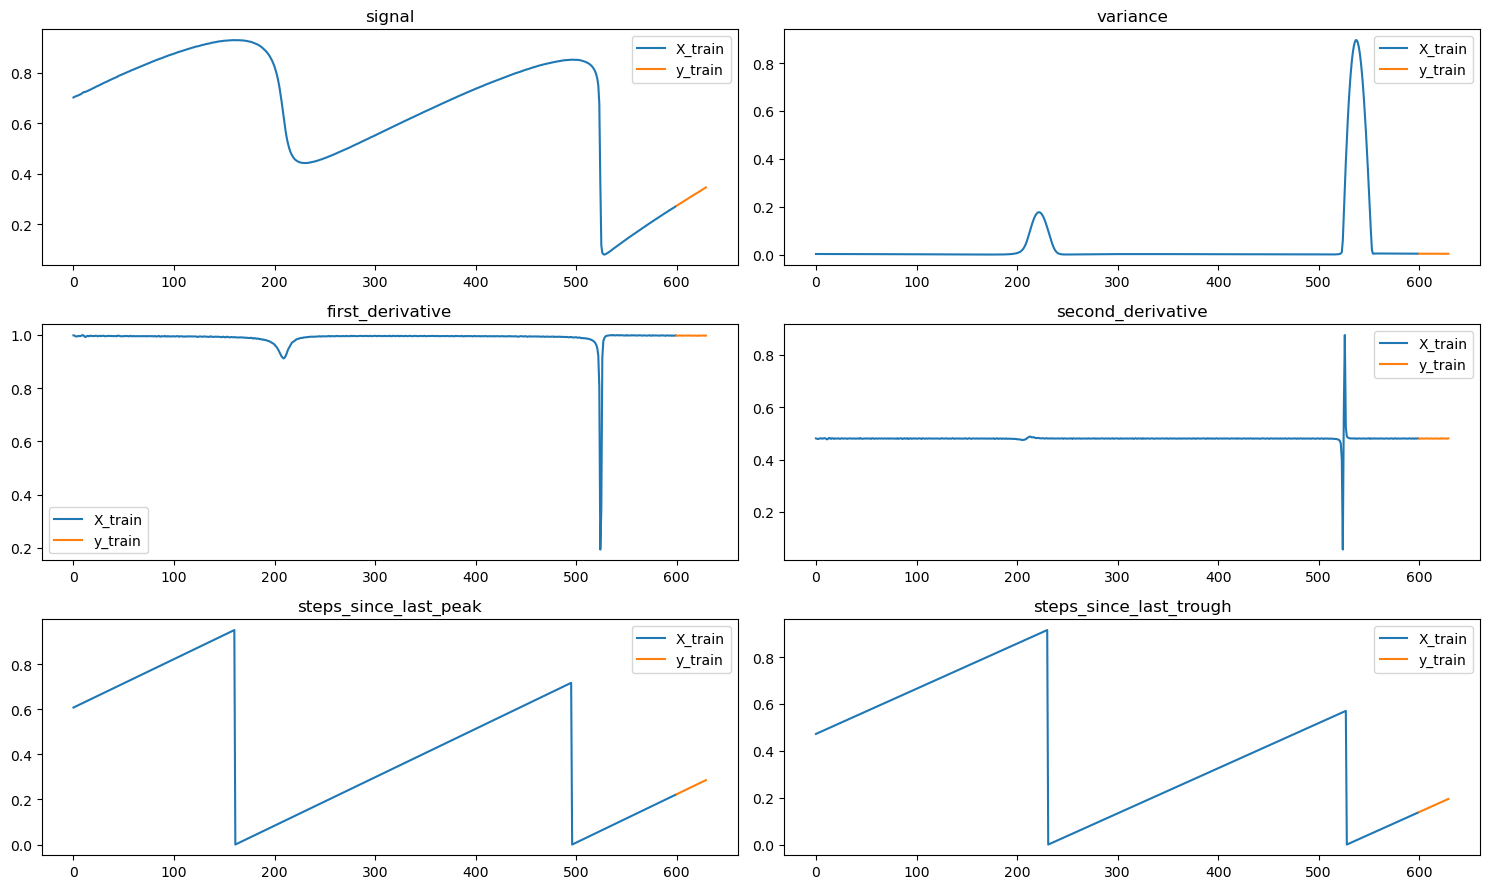

In [11]:
plot_random_window(data_dict_temp, feature_list)

After inspecting the features above, you can decide which ones you would like to train the model with. **Adjust the list variable "features_to_keep" to include the feature names you want to keep.** You can select as many as you want from the following:

`"signal", "variance", "first_derivative", "second_derivative", "steps_since_last_peak", "steps_since_last_trough"`

_Note: it is highly recommended that you keep the "signal" input feature._

The select_features function then creates a finalised data dictionary with tensors ready for training based on the input features selected. 

In [12]:
features_to_keep = ["signal", "first_derivative", "second_derivative"]  # Include one or more of the following variables "signal", "variance", "first_derivative", "second_derivative", "steps_since_last_peak", "steps_since_last_trough"

data_dict = select_features(data_dict_temp, features_to_keep)

print(f"Data Dictionary keys:\t{data_dict.keys()}")
print("------------------")
print("Original dataset statistics:")
print(f"Training data shapes:\t\t{data_dict['X_train'].shape}\t\t{data_dict['y_train'].shape}")
print(f"Testing data shapes:\t\t{data_dict['X_val'].shape}\t\t{data_dict['y_val'].shape}")
print(f"Validation data shapes:\t\t{data_dict['X_test'].shape}\t\t{data_dict['y_test'].shape}")
print("------------------")
print("Normalised dataset statistics:")
print(f"Training data shapes:\t\t{data_dict['X_train_sc'].shape}\t\t{data_dict['y_train_sc'].shape}")
print(f"Validation data shapes:\t\t{data_dict['X_val_sc'].shape}\t\t{data_dict['y_val_sc'].shape}")
print(f"Testing data shapes:\t\t{data_dict['X_test_sc'].shape}\t\t{data_dict['y_test_sc'].shape}")


Data Dictionary keys:	dict_keys(['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val', 'X_train_sc', 'X_test_sc', 'X_val_sc', 'y_train_sc', 'y_test_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([15810, 600, 3])		torch.Size([15810, 30])
Testing data shapes:		torch.Size([3360, 600, 3])		torch.Size([3360, 30])
Validation data shapes:		torch.Size([3360, 600, 3])		torch.Size([3360, 30])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([15810, 600, 3])		torch.Size([15810, 30])
Validation data shapes:		torch.Size([3360, 600, 3])		torch.Size([3360, 30])
Testing data shapes:		torch.Size([3360, 600, 3])		torch.Size([3360, 30])


___
## Step 9: Initialise and train the model

**You can now choose the type of model you want to train (an LSTM or TCN) and set the relevant hyperparameters.** A discussion on these hyperparameters can be found in the report.

In [19]:
# Model variables
model_type = "LSTM" # set to either LSTM or TCN

# General hyperparameters
N_EPOCHS = 200
HIDDEN_SIZE = 25

# LSTM hyperparameters
N_LAYERS = 1

# TCN hyperparameters
KERNEL_SIZE = 10
DROPOUT = 0

# Automatically set hyperparameters
N_VARIATES = data_dict["X_train"].shape[2]
scaler_y = scalers_y[0]
OUTPUT_SIZE = FORECAST

if model_type == "LSTM":

    model = lstm.MultiStepLSTMSingleLayer(
        N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
    ).to(device)
    best_model = lstm.MultiStepLSTMSingleLayer(
        N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
    ).to(device)

elif model_type == "TCN":

    model = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT).to(device)
    best_model = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT).to(device)

**Now run the following cell to execute the "train_model_multi_feature" function, which will train the model.** The training loop will display the train and validation RMSE for each epoch and an estimated completion time. Once complete, the five best epochs and a graph of the train and validation RMSE and R<sup>2</sup> is displayed.

_Note: if you receive a cuda out of memory error, try changing the model to a TCN and/or reducing the hidden_size. As a last resort, you can also increase the downsampling factor, which will significantly reduce the size of the data, however it will also mean that the model will not be transferrable to Cascadia._

Training model on cuda


Best Epoch: 179, Val RMSE: 0.0072 | Last Epoch: [200/200], Train RMSE: 0.0072, Val RMSE: 0.0084: 100%|██████████| 200/200 [07:06<00:00,  2.13s/it]


Five lowest validation RMSEs:
Epoch: 179, Value: 0.007191363722085953 (R^2: 0.9873458768041237)
Epoch: 195, Value: 0.007207768503576517 (R^2: 0.987290577080157)
Epoch: 168, Value: 0.007213478907942772 (R^2: 0.9872687305601268)
Epoch: 157, Value: 0.007222712505608797 (R^2: 0.9872398966543465)
Epoch: 176, Value: 0.007323974743485451 (R^2: 0.9868760502028822)


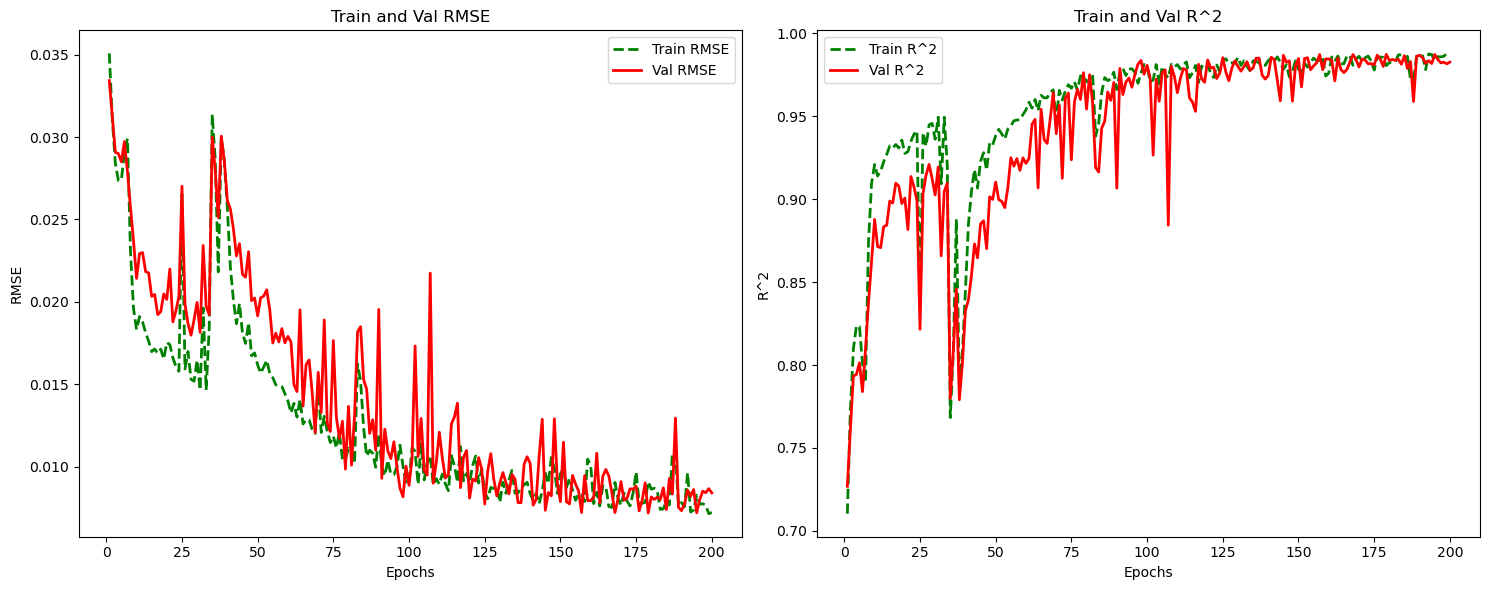

In [20]:
results_dict, best_results_dict = train_model_multi_feature(model, N_EPOCHS, data_dict, scaler_y, device, best_model)

#### Code to print the top 5 epochs and RMSE and R2 charts ####

# Identify and print the five lowest validation RMSEs and their corresponding epochs and R^2 values
print("Five lowest validation RMSEs:")
for index, loss in sorted(enumerate(results_dict["val_rmse_list"]), key=lambda x: x[1])[:5]:
    print(f"Epoch: {index + 1}, Value: {loss} (R^2: {results_dict['val_r2_list'][index]})")

# Plotting RMSE and R^2 for train and validation sets
train_rmse_list, val_rmse_list = results_dict["train_rmse_list"], results_dict["val_rmse_list"]
train_r2_list, val_r2_list = results_dict["train_r2_list"], results_dict["val_r2_list"]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# RMSE plot
axs[0].plot(range(1, len(train_rmse_list) + 1), train_rmse_list, label="Train RMSE", color="green", linestyle="--", linewidth=2)
axs[0].plot(range(1, len(val_rmse_list) + 1), val_rmse_list, label="Val RMSE", color="red", linestyle="-", linewidth=2)
axs[0].set(title="Train and Val RMSE", xlabel="Epochs", ylabel="RMSE")
axs[0].legend()

# R^2 plot
axs[1].plot(range(1, len(train_r2_list) + 1), train_r2_list, label="Train R^2", color="green", linestyle="--", linewidth=2)
axs[1].plot(range(1, len(val_r2_list) + 1), val_r2_list, label="Val R^2", color="red", linestyle="-", linewidth=2)
axs[1].set(title="Train and Val R^2", xlabel="Epochs", ylabel="R^2")
axs[1].legend()

plt.tight_layout()
plt.show()

___
## Step 10: Evaluate the model's performance and plot sample test windows

The next cell now runs the "eval_model_on_test_set_multi_feature" function to evaluate the model on the test set. The train, validation and test statistics and a random window from the test set is then displayed for visual inspection. **You can run the cell multiple times to view different windows and inspect the models performance at different stages in the cycle.**

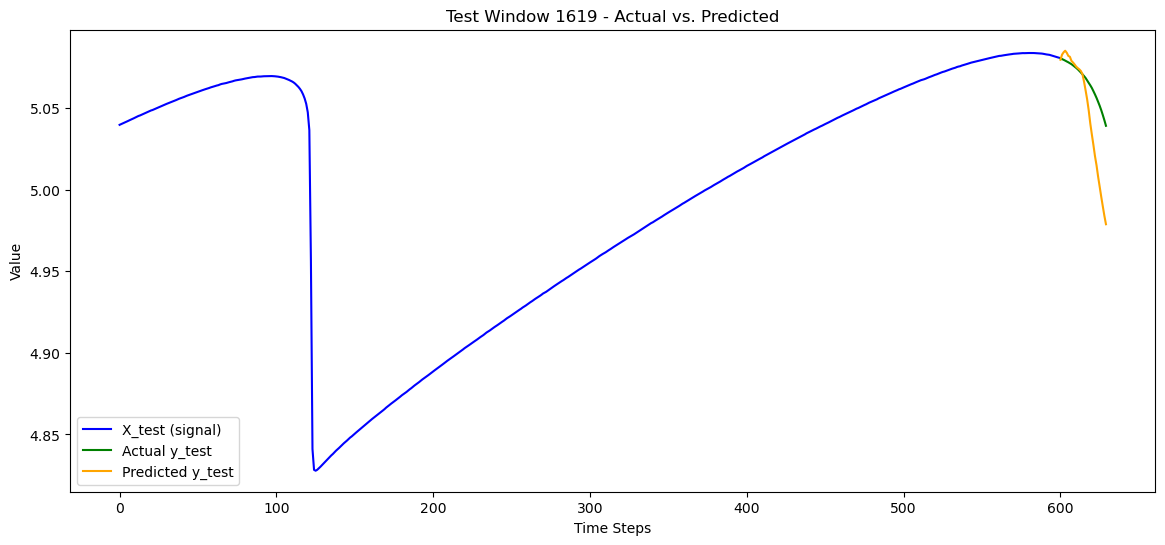

*** Final Performance Statistics ***

Train RMSE: 0.0091
Val RMSE: 0.0072
Test RMSE: 0.0147

Train R^2: 0.9806
Val R^2: 0.9873
Test R^2: 0.9462

--------------

*** Scaled Statistics (for comparison with Laurenti et al. only) ***

Scaled Test RMSE: 0.0523
Scaled Test R^2: 0.9462


In [93]:
best_results_dict = eval_model_on_test_set_multi_feature(
    best_model, best_results_dict, data_dict, scaler_y, device
)

plot_random_test_window(data_dict, best_results_dict)

print("*** Final Performance Statistics ***")
print(f"\nTrain RMSE: {best_results_dict['train_rmse']:.4f}")
print(f"Val RMSE: {best_results_dict['val_rmse']:.4f}")
print(f"Test RMSE: {best_results_dict['test_rmse']:.4f}")
print(f"\nTrain R^2: {best_results_dict['train_r2']:.4f}")
print(f"Val R^2: {best_results_dict['val_r2']:.4f}")
print(f"Test R^2: {best_results_dict['test_r2']:.4f}")
print("\n--------------")
print("\n*** Scaled Statistics (for comparison with Laurenti et al. only) ***")
print(f"\nScaled Test RMSE: {best_results_dict['test_rmse_sc']:.4f}")
print(f"Scaled Test R^2: {best_results_dict['test_r2_sc']:.4f}")

## Step 11: Save or load the model and results dictionary (if required)

The following code allows you to save the best model and results dictionary, allowing you to load it into a future session of this notebook without having to run Steps 2 to 10 again. You will still need to run the imports cell in Step 1.

### Save the model and results dictionary

In [22]:
save_model = False  # Set to "True" if you want to save the model and results dictionaries

if save_model:

    # Saves the model, results/data dictionaries and hyperparameters in the results folder
    
    torch.save(best_model.state_dict(), "../results/best_model.pt")

    with open('../results/best_results_dict.pkl', 'wb') as file:
        pickle.dump(best_results_dict, file)

    with open('../results/results_dict.pkl', 'wb') as file:
        pickle.dump(results_dict, file)

    with open('../results/data_dict.pkl', 'wb') as file:
        pickle.dump(data_dict, file)

    hyperparameters = {
        "N_VARIATES": N_VARIATES,
        "LOOKBACK": LOOKBACK,
        "OUTPUT_SIZE": OUTPUT_SIZE,
        "HIDDEN_SIZE": HIDDEN_SIZE,
        "KERNEL_SIZE": KERNEL_SIZE,
        "DROPOUT": DROPOUT,
        "scaler_y" : scaler_y,
        "model_type" : model_type,
        "N_LAYERS" : N_LAYERS
    }

    with open("../results/hyperparameters.pkl", "wb") as file:
        pickle.dump(hyperparameters, file)


### Load the model and results dictionary

In [23]:
load_model_from_file = False   # Set to "True" if you want to skip the previous steps and load a pre-trained model and dictionaries

if load_model_from_file:

    # Loads the model, results/data dictionaries and hyperparameters from the results folder
    filepath_best_results_dict = '../results/best_results_dict.pkl'
    filepath_results_dict = '../results/results_dict.pkl'
    filepath_data_dict = '../results/data_dict.pkl'
    filepath_hyperparameters = '../results/hyperparameters.pkl'

    state_dict = torch.load('../results/best_model.pt')
    
    with open(filepath_best_results_dict, 'rb') as file:  
        best_results_dict = pickle.load(file)
        
    with open(filepath_results_dict, 'rb') as file:  
        results_dict = pickle.load(file)
        
    with open(filepath_data_dict, 'rb') as file:  
        data_dict = pickle.load(file)

    with open(filepath_hyperparameters, 'rb') as file:
        hyperparameters = pickle.load(file)

    # Extract the variables from the hyperparameters dictionary
    N_VARIATES = hyperparameters['N_VARIATES']
    LOOKBACK = hyperparameters['LOOKBACK']
    OUTPUT_SIZE = hyperparameters['OUTPUT_SIZE']
    HIDDEN_SIZE = hyperparameters['HIDDEN_SIZE']
    KERNEL_SIZE = hyperparameters['KERNEL_SIZE']
    DROPOUT = hyperparameters['DROPOUT']
    N_LAYERS = hyperparameters['N_LAYERS']
    scaler_y = hyperparameters['scaler_y']
    model_type = hyperparameters['model_type']

    # Initialise the model
    if model_type == "LSTM":
        best_model = lstm.MultiStepLSTMSingleLayer(
            N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
        ).to(device)
    elif model_type == "TCN":
        best_model = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT).to(device)

    # Set the model state
    best_model.load_state_dict(state_dict)

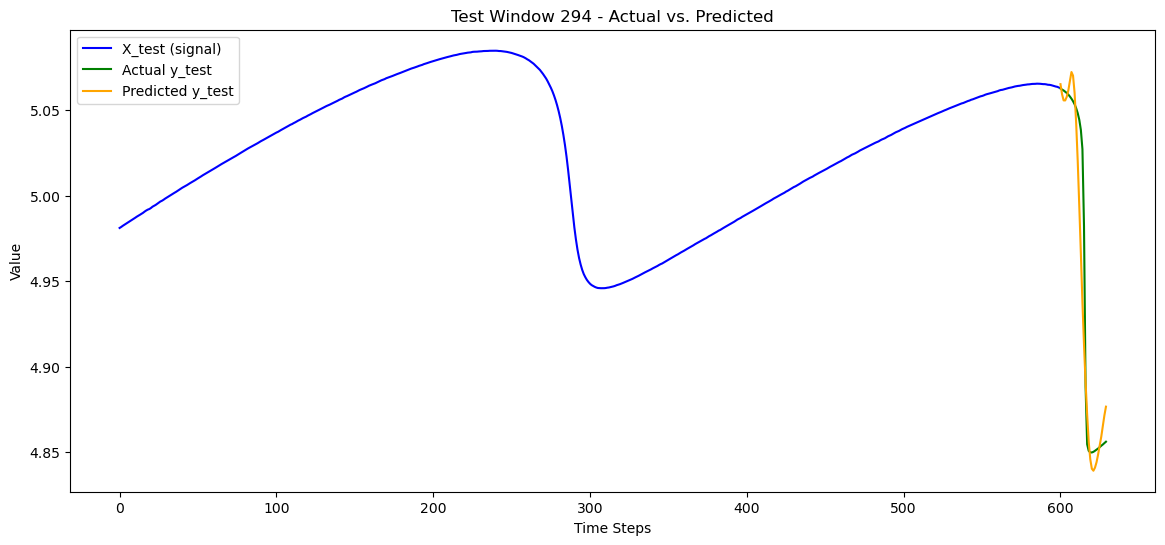

*** Final Performance Statistics ***

Train RMSE: 0.0091
Val RMSE: 0.0072
Test RMSE: 0.0147

Train R^2: 0.9806
Val R^2: 0.9873
Test R^2: 0.9462

--------------

*** Scaled Statistics (for comparison with Laurenti et al. only) ***

Scaled Test RMSE: 0.0523
Scaled Test R^2: 0.9462


In [98]:
# This cell repeats the code from Step 10, allowing you to inspect the model's performance on multiple windows

plot_random_test_window(data_dict, best_results_dict)

print("*** Final Performance Statistics ***")
print(f"\nTrain RMSE: {best_results_dict['train_rmse']:.4f}")
print(f"Val RMSE: {best_results_dict['val_rmse']:.4f}")
print(f"Test RMSE: {best_results_dict['test_rmse']:.4f}")
print(f"\nTrain R^2: {best_results_dict['train_r2']:.4f}")
print(f"Val R^2: {best_results_dict['val_r2']:.4f}")
print(f"Test R^2: {best_results_dict['test_r2']:.4f}")
print("\n--------------")
print("\n*** Scaled Statistics (for comparison with Laurenti et al. only) ***")
print(f"\nScaled Test RMSE: {best_results_dict['test_rmse_sc']:.4f}")
print(f"Scaled Test R^2: {best_results_dict['test_r2_sc']:.4f}")
